#### **Задание: необходимо спрогнозировать таргеты, где значения -1.**

Можно использовать только  интерпретируемые модели для прогнозирования (это необходимо для корректной оценки способностей)  

In [1]:
# Принудительно отключим предупреждения системы
import warnings
warnings.simplefilter(action = 'ignore', category = Warning)

# Импортируем библиотеки
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import f_oneway
import plotly.express as px
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, roc_curve, roc_auc_score

In [2]:
# Импортируем функции
%run '~/Applications/Test-tasks-for-companies/Test tasks for "ВСК"/Solution/functions.py'

In [3]:
# Импортируем данные
sheet_name_variables = 'Переменные'
sheet_name = 'data_full'

df_variables = pd.read_excel('~/Applications/Test-tasks-for-companies/Test tasks for "ВСК"/Test/Задание (пролонгация).xlsx', sheet_name=sheet_name_variables)
df = pd.read_excel('~/Applications/Test-tasks-for-companies/Test tasks for "ВСК"/Test/Задание (пролонгация).xlsx', sheet_name=sheet_name, index_col='ID')

print('Размер датасета:', df.shape)

Размер датасета: (10863, 29)


In [4]:
# При анализе найдены дубликаты
df = df.drop_duplicates()

In [5]:
# Сделаем анализ тех данных, на которых будем проводить обучение и тестироваться
df_train = df[df['target'] != -1]

In [6]:
# Разведовательный анализ данных по датасету
EDA(df_train)

Shape DataFrame:

(7576, 29) 

Basic information:

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7576 entries, 1 to 7598
Data columns (total 29 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Filial           7576 non-null   object 
 1   Type_ts          7576 non-null   object 
 2   passport_region  7576 non-null   object 
 3   VIP              205 non-null    object 
 4   Brand            7576 non-null   object 
 5   Model            7576 non-null   object 
 6   Yr_production    7576 non-null   int64  
 7   GAP              7576 non-null   object 
 8   married          7576 non-null   object 
 9   KBM              7576 non-null   int64  
 10  KBM_prol_est     7576 non-null   int64  
 11  delta_kbm        7576 non-null   int64  
 12  deduct           7576 non-null   object 
 13  deduct_amount    7576 non-null   object 
 14  product          7576 non-null   object 
 15  Bank             7576 non-null   object 
 16  channel -

In [7]:
# Признак VIP удалим, 97% значений в нем заполнены Nan
df_train = df_train.drop(columns=['VIP'], axis=1)

Для проверки того, какие признаки следует включить в модель, можно воспользоваться различными методами отбора признаков. 

Можно вычислить корреляцию между каждым признаком и целевой переменной (меткой класса) и оставить только те признаки, которые имеют наибольшую корреляцию с целевой переменной.

In [8]:
# Посмотрим на коррекляцию числовых признаков
numeric = df_train.select_dtypes(include = np.number)
numeric_columns= numeric.columns
numeric_features = list(numeric_columns) 

df_with_numeric_features = df[numeric_features]

In [9]:
# Вычисляем корреляцию Пирсона между признаками и целевой переменной
correlation_matrix = df_with_numeric_features.corr()

# Выводим абсолютные значения корреляции для целевой переменной
correlation_with_target = correlation_matrix['target'].abs().sort_values(ascending=False)

# Печатаем признаки с наибольшей корреляцией с целевой переменной
print(correlation_with_target)

target           1.000000
KBM_prol_est     0.119907
KBM              0.116491
Yr_production    0.100183
price_prc        0.066242
delta_kbm        0.055614
Age              0.040398
OSAGO_clnt       0.035456
premium_car      0.034748
price_gr         0.031033
Exp              0.023892
Amount - gr      0.021870
discount         0.004813
Name: target, dtype: float64


На основании коэффициентов корреляции Пирсона я бы выбрала следующие фичи:

- KBM_prol_est: Этот признак имеет наивысший коэффициент корреляции с целевой переменной, что указывает на его сильное влияние на результаты модели.
- KBM: Также имеет довольно высокий коэффициент корреляции, что означает его важность для модели.
- Yr_production: Этот признак также имеет относительно высокий коэффициент корреляции и может быть важным для предсказания целевой переменной.

Эти признаки были выбраны на основании их сильной корреляции с целевой переменной, что указывает на их потенциальную значимость для модели. Однако, при выборе признаков для модели также важно учитывать их интерпретируемость, доступность и другие факторы, связанные с конкретной задачей и предметной областью.

В основном корреляция Пирсона используется для оценки линейных взаимосвязей между числовыми признаками и целевой переменной. Если у вас есть категориальные признаки и вы хотите оценить их влияние на целевую переменную, вы можете использовать методы, такие как анализ дисперсии (ANOVA) или непараметрические тесты, такие как тест Крускала-Уоллиса для оценки связи между категориальными и числовыми переменными.

In [10]:
# Категориальные фичи

categorical = df_train.select_dtypes(include = object)
categorical_columns = categorical.columns
categorical_features = list(categorical_columns) 

df_with_cat_features = df_train[categorical_features]

In [11]:
target_variable = 'target'  # Имя целевой переменной

for feature in categorical_features:
    # Разделение данных по уникальным значениям категориального признака
    groups = []
    for category in df_train[feature].unique():
        groups.append(df_train[df_train[feature] == category][target_variable])
    
    # Проведение ANOVA
    f_statistic, p_value = f_oneway(*groups)
    
    # Вывод результатов
    print(f"ANOVA for {feature}: F-statistic={f_statistic}, p-value={p_value}")

# Этот код оценивает статистическую значимость различий в средних значениях целевой переменной между 
# различными категориями каждого категориального признака. 

ANOVA for Filial: F-statistic=10.762113806516975, p-value=1.0361731044967214e-35
ANOVA for Type_ts: F-statistic=37.858325725812925, p-value=7.994276317592796e-10
ANOVA for passport_region: F-statistic=3.6365060666002846, p-value=3.345614328874103e-26
ANOVA for Brand: F-statistic=8.533604176417848, p-value=6.9956740528627e-28
ANOVA for Model: F-statistic=2.7260605852362874, p-value=1.5755026491888066e-30
ANOVA for GAP: F-statistic=33.39981655178175, p-value=7.800626344299378e-09
ANOVA for married: F-statistic=14.586386784921547, p-value=0.00013494742627141493
ANOVA for deduct: F-statistic=27.95000899146416, p-value=8.054643238000622e-13
ANOVA for deduct_amount: F-statistic=22.522209758338363, p-value=1.7689004138394373e-10
ANOVA for product: F-statistic=53.2368318031928, p-value=4.806193942826934e-34
ANOVA for Bank: F-statistic=171.54324394803558, p-value=1.374025661582833e-73
ANOVA for channel - map: F-statistic=122.25362359838576, p-value=3.3360000082598846e-28
ANOVA for category: F-s

На основании результатов теста ANOVA можно сделать вывод, что все рассмотренные признаки являются статистически значимыми предикторами целевой переменной. Значения p-значений для всех признаков ниже уровня значимости 0.05, а F-статистика относительно высока, что указывает на существенное влияние признаков на целевую переменную.

Выбор признаков для модели зависит от конкретной задачи и целей анализа. 

В данном случае, я выбрала признаки "Bank", "Category" и "Product" на основании их высокой статистической значимости, которая была подтверждена результатами теста ANOVA. Выбор этих признаков может быть обоснован их сильным влиянием на целевую переменную и важностью для достижения целей анализа. 

Однако, конечное решение о выборе признаков для модели должно приниматься на основании дополнительных факторов, таких как знания области предмета и экспертное мнение.

**В рамках данного тестового задания, в связи с ограниченным временем и ресурсами, я приняла решение сосредоточиться на анализе трех наиболее значимых категориальных и трех наиболее значимых числовых фичей, исходя из результатов проведенных тестов и анализа данных.**

In [12]:
df_train_change = df_train[['KBM_prol_est', 'KBM', 'Yr_production', 'Bank', 'category', 'product', 'target']]

# KBM_prol_est = Прогноз КБМ (пролонгация)
# KBM = КБМ
# Yr_production = Год выпуска ТС
# Bank = Машина в залоге банка
# category = Тип бизнеса
# product = Продукт

In [13]:
def plot_col_with_FacetGrid(value_column, name_column):
    
    # Создание объекта FacetGrid с настройками размеров
    g = sns.FacetGrid(df_train_change, col="target", height=4, aspect=1.2)

    # Настройка графиков
    g.map(sns.histplot, f"{value_column}", bins=10, kde=True, color="pink")
    g.set_axis_labels(f"{name_column}", "Частота")
    g.set_titles("Целевая переменная: {col_name}")

    # Добавление легенды
    g.add_legend()

    # Отображение графиков
    plt.show()

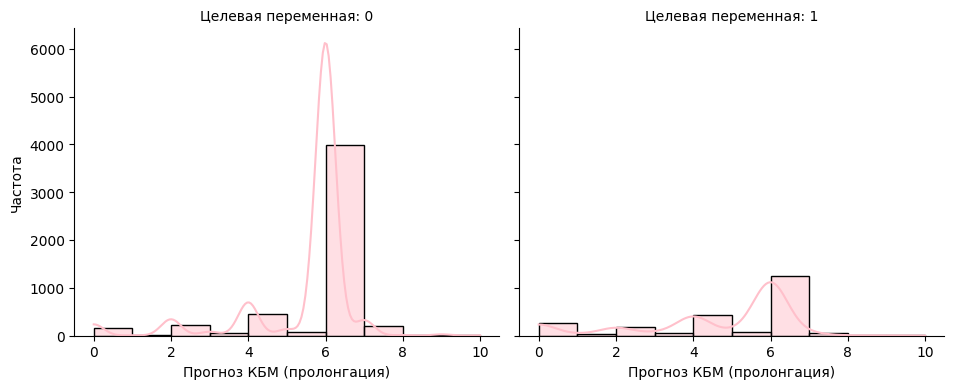

In [14]:
plot_col_with_FacetGrid('KBM_prol_est', 'Прогноз КБМ (пролонгация)')

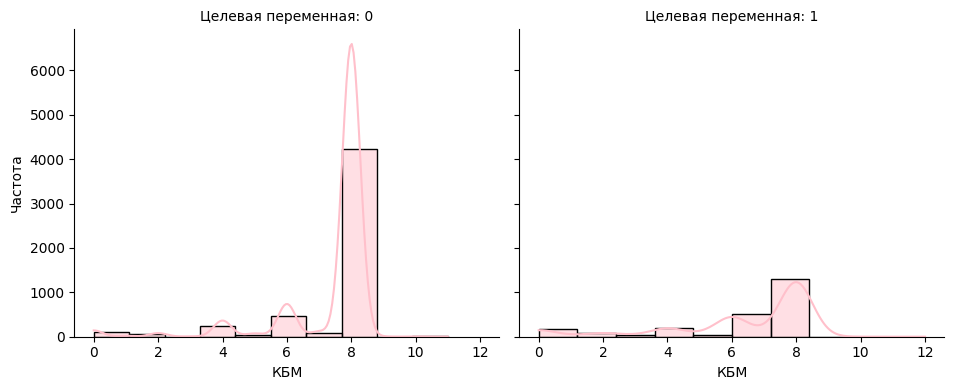

In [15]:
plot_col_with_FacetGrid('KBM', 'КБМ')

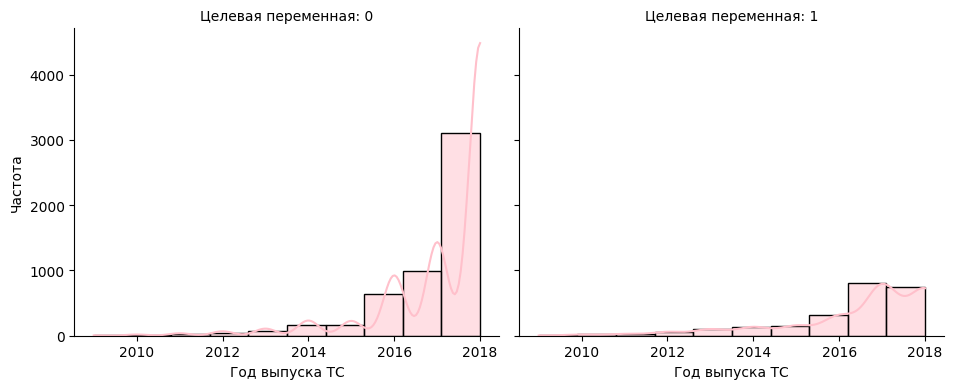

In [16]:
plot_col_with_FacetGrid('Yr_production', 'Год выпуска ТС')

Признаки 'KBM_prol_est', 'KBM' являются не числовыми, а категориальными, так как они содержат дискретные значения, которые представляют различные категории или уровни. Категориальные признаки представляют собой переменные, которые могут принимать ограниченное количество уникальных значений из определенного набора категорий. 

Также признак "Год выпуска ТС" (Yr_production) в данном случае представляет собой категориальный признак. В данном контексте год выпуска транспортного средства является дискретной категорией, и его можно рассматривать как категориальный признак. Каждый год представляет отдельную категорию, а количество транспортных средств выпущенных в каждом году указывает на количество наблюдений в соответствующей категории.

In [17]:
# Закодируем сразу и тренировочные, и тестовые данные
df_predict = df[df['target'] == -1][['KBM_prol_est', 'KBM', 'Yr_production', 'Bank', 'category', 'product']]

In [18]:
# "KBM_prol_est", "KBM" уже закодированы, рассмотрим остальные

cat_cols = ["Yr_production", "Bank", "category", "product"]

# Создание одного объекта LabelEncoder
encoder = LabelEncoder()

# Объединение тренировочного и тестового наборов данных для обеспечения единых меток
combined_df = pd.concat([df_train_change, df_predict])

# Применение LabelEncoder к каждому категориальному признаку
for col in cat_cols:
    combined_df[col] = encoder.fit_transform(combined_df[col])

# Разделение обратно на тренировочный и тестовый наборы данных
df_train_change = combined_df[:len(df_train_change)]
df_predict = combined_df[len(df_train_change):]

df_predict = df_predict.drop(['target'], axis=1)

# Вывод обновленного датафрейма
df_train_change.head(3)

,KBM_prol_est,KBM,Yr_production,Bank,category,product,target
ID,,,,,,,
1,6,8,9,0,0,1,0.0
2,6,8,7,0,2,2,0.0
3,6,8,9,0,0,1,1.0


Стандартизация или нормализация обычно не требуется для закодированных категориальных признаков, так как они уже представлены в форме числовых значений после процесса кодирования. Эти числовые значения обычно представляют собой целые числа или коды, которые обозначают различные категории.

In [19]:
# Разделение данных на обучающий и тестовый наборы
X = df_train_change.drop(columns=['target'])
y = df_train_change['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Инициализация и обучение модели логистической регрессии
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)

# Оценка качества модели с использованием кросс-валидации
cv_scores = cross_val_score(log_reg, X_train, y_train, cv=5)
print("Значения кросс-валидации:", cv_scores)
print("Средняя точность кросс-валидации:", cv_scores.mean())

# Оценка качества модели на тестовом наборе данных
test_accuracy = log_reg.score(X_test, y_test)
print("Точность на тестовом наборе данных:", test_accuracy)

Значения кросс-валидации: [0.6980198  0.7029703  0.70874587 0.70214521 0.70214521]
Средняя точность кросс-валидации: 0.7028052805280527
Точность на тестовом наборе данных: 0.7170184696569921


Полученные результаты показывают, что модель логистической регрессии достаточно неплохо обобщает данные, хотя качество на тестовом наборе данных немного ниже, чем на обучающем наборе данных. Это может указывать на то, что модель немного переобучена на обучающих данных. Тем не менее, общее качество модели выглядит приемлемым.

In [20]:
# Предсказание меток классов на новом наборе данных
y_pred = log_reg.predict(df_predict)

result = pd.concat([df_predict, pd.DataFrame(y_pred, columns=['y_pred'], index=df_predict.index)], axis=1)